<a href="https://colab.research.google.com/github/Testoxe/EuroMoneyRecognition/blob/main/Project_EuroMoneyRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Project: Money value recognition (Euro)**

**I - Loading data and preprocessing:**
---



**0 - Importing python libraries:**

In [ ]:
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import keras
from keras import layers, models, optimizers, regularizers
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16
from sklearn.metrics import classification_report,confusion_matrix


import pandas as pd
import tensorflow as tf
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat
import itertools

**1 - Git loading:**

In [ ]:
!git clone https://github.com/Testoxe/EuroMoneyRecognition.git
path = "./EuroMoneyRecognition/data/"

Cloning into 'EuroMoneyRecognition'...
remote: Enumerating objects: 4388, done.
remote: Total 4388 (delta 0), reused 0 (delta 0), pack-reused 4388
Receiving objects: 100% (4388/4388), 259.15 MiB | 45.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Checking out files: 100% (4505/4505), done.


**2 - Data loading script:**

In [ ]:
def load_data(data_path, classes, dataset='train', image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, len(classes)))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index][idx_class] = 1
                current_index += 1
                
    return x, y

**3 - Loading the data using the script**: 

In [ ]:
labels = ['1c', '2c', '5c', '10c', '20c', '50c', '1e', '2e', '5e', '10e', '20e', '50e', '100e']

x_train, y_train = load_data(path, labels, dataset='training', image_size=150)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=150)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=150)
print(x_test.shape, y_test.shape)

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(3359, 150, 150, 3) (3359, 13)
(575, 150, 150, 3) (575, 13)
(567, 150, 150, 3) (567, 13)


**4 - Testing the loaded data:**

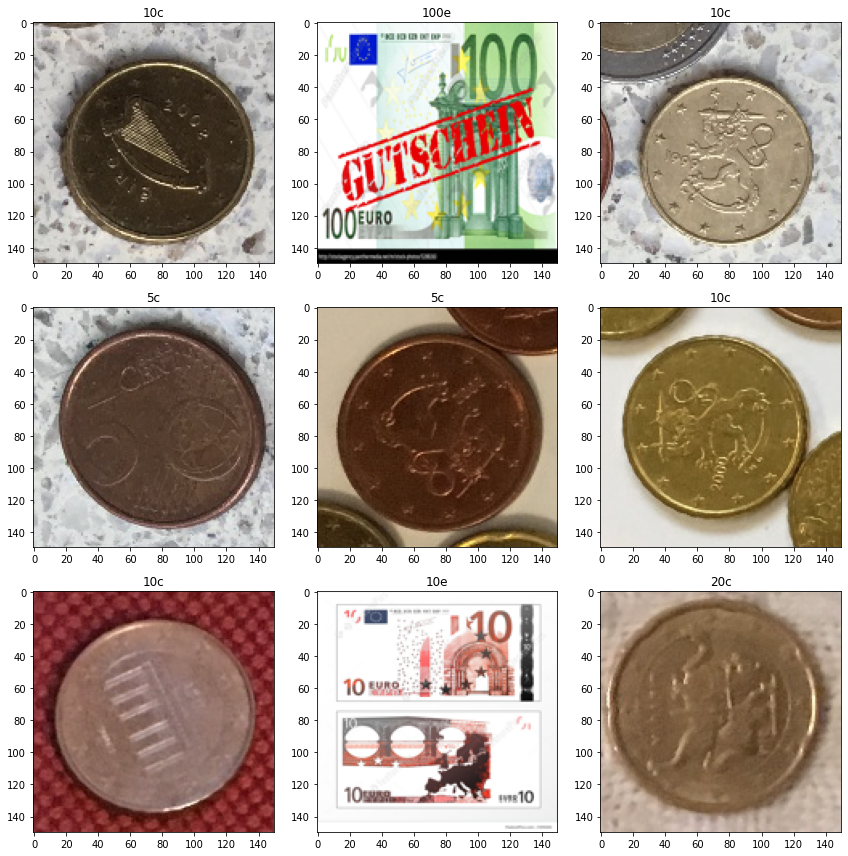

In [ ]:
plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(3300)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    index = list(y_train[shuffle_indices[i]]).index(1)
    plt.title(labels[index])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

**5 - Data augmentation:**

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

train_generator_augmented = train_datagen.flow(
    x_train,
    y_train
)

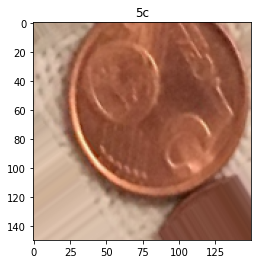

In [ ]:
# Overview
example_x, example_y = train_generator_augmented.next()
for i in range(0,1):
    plt.imshow(example_x[i])
    plt.title(labels[list(example_y[i]).index(1)])
    plt.show()

**6 - Utility functions:**

In [ ]:
# Result plot
def plot_training_analysis(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

**II - Neural networks:**
---

**1 - Simple initial version:**

In [ ]:
model = models.Sequential()

#Convolution
model.add(Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(96, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, activation='relu'))
model.add(MaxPooling2D())

#Flatten
model.add(Flatten())

# Fully connected
model.add(Dense(512, activation='relu', input_dim=128))
model.add(Dense(13, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20)

Epoch 1/20
105/105 [==============================] - 4s 33ms/step - loss: 5.0074 - acc: 0.2498 - val_loss: 1.3250 - val_acc: 0.5583
Epoch 2/20
105/105 [==============================] - 3s 30ms/step - loss: 1.1447 - acc: 0.6246 - val_loss: 0.8999 - val_acc: 0.6922
Epoch 3/20
105/105 [==============================] - 3s 30ms/step - loss: 0.7760 - acc: 0.7479 - val_loss: 0.7306 - val_acc: 0.7513
Epoch 4/20
105/105 [==============================] - 3s 30ms/step - loss: 0.6015 - acc: 0.7858 - val_loss: 0.6075 - val_acc: 0.7687
Epoch 5/20
105/105 [==============================] - 3s 30ms/step - loss: 0.4432 - acc: 0.8621 - val_loss: 0.5843 - val_acc: 0.8139
Epoch 6/20
105/105 [==============================] - 3s 30ms/step - loss: 0.4004 - acc: 0.8529 - val_loss: 0.5438 - val_acc: 0.8087
Epoch 7/20
105/105 [==============================] - 3s 30ms/step - loss: 0.2851 - acc: 0.9033 - val_loss: 0.5494 - val_acc: 0.8330
Epoch 8/20
105/105 [==============================] - 3s 30ms/step - 

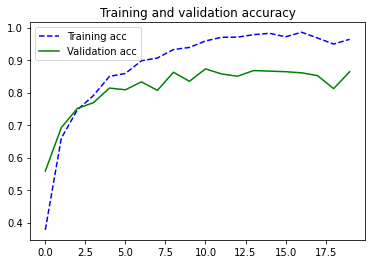

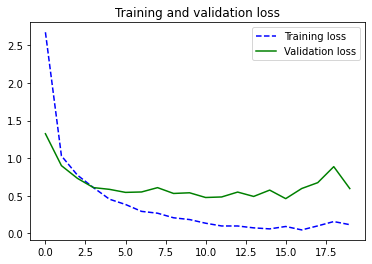

In [ ]:
plot_training_analysis(history)

**2 - Adding regularization:**

In [ ]:
model_reg = models.Sequential()

#Convolution
model_reg.add(Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
model_reg.add(MaxPooling2D())
model_reg.add(Conv2D(64, 3, activation='relu'))
model_reg.add(MaxPooling2D())
model_reg.add(Conv2D(96, 3, activation='relu'))
model_reg.add(MaxPooling2D())
model_reg.add(Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)))
model_reg.add(MaxPooling2D())

#Flatten
model_reg.add(GlobalAveragePooling2D())

# Fully connected
model_reg.add(Dense(512, activation='relu', input_dim=128, kernel_regularizer=regularizers.l2(0.01)))
model_reg.add(Dense(13, activation='softmax'))

model_reg.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

model_reg.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [ ]:
history_reg = model_reg.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=61)

Epoch 1/61
105/105 [==============================] - 37s 39ms/step - loss: 5.9703 - acc: 0.2407 - val_loss: 3.4305 - val_acc: 0.4730
Epoch 2/61
105/105 [==============================] - 3s 29ms/step - loss: 3.2459 - acc: 0.4889 - val_loss: 2.7444 - val_acc: 0.5496
Epoch 3/61
105/105 [==============================] - 3s 29ms/step - loss: 2.6385 - acc: 0.6016 - val_loss: 2.3267 - val_acc: 0.6087
Epoch 4/61
105/105 [==============================] - 3s 29ms/step - loss: 2.2531 - acc: 0.6556 - val_loss: 2.1235 - val_acc: 0.6574
Epoch 5/61
105/105 [==============================] - 3s 29ms/step - loss: 2.0392 - acc: 0.7108 - val_loss: 1.9744 - val_acc: 0.6817
Epoch 6/61
105/105 [==============================] - 3s 30ms/step - loss: 1.8888 - acc: 0.7393 - val_loss: 1.7550 - val_acc: 0.7548
Epoch 7/61
105/105 [==============================] - 3s 30ms/step - loss: 1.7882 - acc: 0.7590 - val_loss: 1.7380 - val_acc: 0.7600
Epoch 8/61
105/105 [==============================] - 3s 30ms/step -

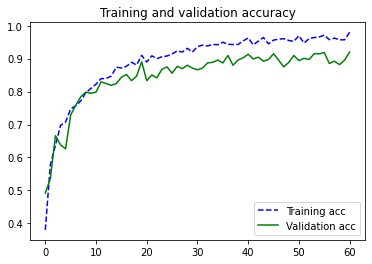

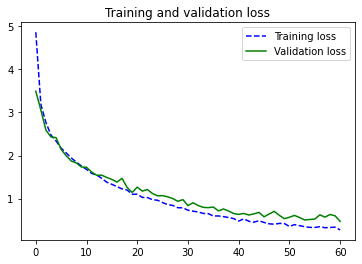

In [ ]:
plot_training_analysis(history_reg)

**3 - Using augmented data:**

In [ ]:
model_aug = models.Sequential()

#Convolution
model_aug.add(Conv2D(32, 3, activation='relu', input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D())
model_aug.add(Conv2D(64, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_aug.add(MaxPooling2D())
model_aug.add(Conv2D(96, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_aug.add(MaxPooling2D())
model_aug.add(Conv2D(128, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_aug.add(MaxPooling2D())
model_aug.add(Conv2D(256, 3, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_aug.add(MaxPooling2D())

#Flatten
model_aug.add(Flatten())

# Fully connected
model_aug.add(Dense(512, activation='relu', input_dim=128, kernel_regularizer=regularizers.l2(0.01)))
model_aug.add(Dense(13, activation='softmax'))

model_aug.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

model_aug.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 34, 34, 96)        55392     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 15, 15, 128)      

In [ ]:
history_aug = model_aug.fit(train_generator_augmented, validation_data=(x_val, y_val), epochs=50)

Epoch 1/50
105/105 [==============================] - 18s 164ms/step - loss: 9.3244 - acc: 0.1748 - val_loss: 139.8448 - val_acc: 0.3130
Epoch 2/50
105/105 [==============================] - 17s 162ms/step - loss: 3.8493 - acc: 0.2930 - val_loss: 147.7460 - val_acc: 0.2713
Epoch 3/50
105/105 [==============================] - 17s 161ms/step - loss: 2.5960 - acc: 0.3831 - val_loss: 188.1937 - val_acc: 0.3913
Epoch 4/50
105/105 [==============================] - 17s 161ms/step - loss: 2.1588 - acc: 0.4295 - val_loss: 204.3154 - val_acc: 0.3426
Epoch 5/50
105/105 [==============================] - 17s 162ms/step - loss: 1.9188 - acc: 0.4685 - val_loss: 129.0807 - val_acc: 0.4661
Epoch 6/50
105/105 [==============================] - 17s 161ms/step - loss: 1.6846 - acc: 0.5345 - val_loss: 141.2754 - val_acc: 0.5061
Epoch 7/50
105/105 [==============================] - 17s 162ms/step - loss: 1.5721 - acc: 0.5391 - val_loss: 169.7130 - val_acc: 0.4626
Epoch 8/50
105/105 [=====================

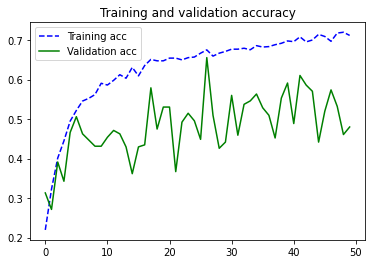

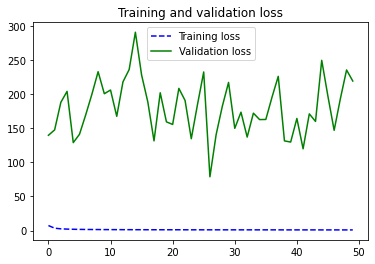

In [ ]:
plot_training_analysis(history_aug)

**III - Transfer learning:**
---

**1 - Using locked VGG-16:**

In [ ]:
conv_base = VGG16(weights='imagenet', # We use the pretrained model on the ImageNet database
                  include_top=False, # We dispose of the dense part
                  input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],4*4*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],4*4*512))

In [ ]:
model_tl = models.Sequential()
model_tl.add(layers.Dense(256, activation='relu', input_dim=4*4*512))
model_tl.add(layers.Dropout(0.5)) # On utilise du DropOut sur cette couche dense car elle comporte un grand nombre
                               # de paramètres et risque d'être très sujette au sur-apprentissage.
model_tl.add(layers.Dense(13, activation='softmax'))

model_tl.compile(optimizer=optimizers.Adam(lr=3e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

history_tl = model_tl.fit(train_features, y_train,
                    epochs=30,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Epoch 1/30
210/210 [==============================] - 1s 4ms/step - loss: 1.6427 - acc: 0.3304 - val_loss: 0.2223 - val_acc: 0.6330
Epoch 2/30
210/210 [==============================] - 1s 3ms/step - loss: 0.3405 - acc: 0.5702 - val_loss: 0.1495 - val_acc: 0.7287
Epoch 3/30
210/210 [==============================] - 1s 3ms/step - loss: 0.2136 - acc: 0.7054 - val_loss: 0.1428 - val_acc: 0.7843
Epoch 4/30
210/210 [==============================] - 1s 3ms/step - loss: 0.1470 - acc: 0.7937 - val_loss: 0.1336 - val_acc: 0.7948
Epoch 5/30
210/210 [==============================] - 1s 3ms/step - loss: 0.1209 - acc: 0.8205 - val_loss: 0.1258 - val_acc: 0.8139
Epoch 6/30
210/210 [==============================] - 1s 3ms/step - loss: 0.1048 - acc: 0.8594 - val_loss: 0.1285 - val_acc: 0.8174
Epoch 7/30
210/210 [==============================] - 1s 3ms/step - loss: 0.0914 - acc: 0.8715 - val_loss: 0.1138 - val_acc: 0.8365
Epoch 8/30
210/210 [==============================] - 1s 4ms/step - loss: 0.

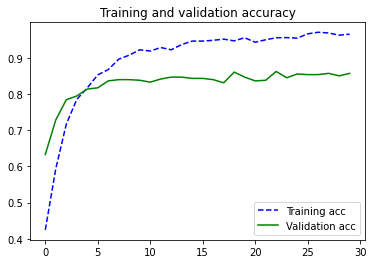

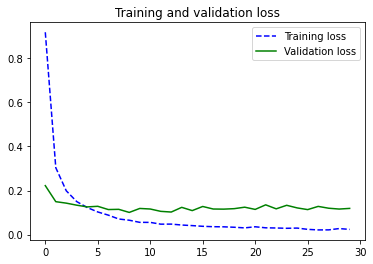

In [ ]:
plot_training_analysis(history_tl)

**2 - Integration du VGG:**

In [ ]:
model_transfl = models.Sequential()
model_transfl.add(conv_base) # VGG-16 layer
model_transfl.add(layers.Flatten())
model_transfl.add(layers.Dense(256, activation='relu'))
model_transfl.add(layers.Dense(13, activation='softmax'))

conv_base.trainable = False

model_transfl.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_7 (Dense)              (None, 13)                3341      
Total params: 16,815,437
Trainable params: 2,100,749
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model_transfl.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=3e-4),
              metrics=['acc'])

history_transfl = model_transfl.fit(
    x_train, y_train,
    epochs=50,
    validation_data=(x_val, y_val))

Epoch 1/50
105/105 [==============================] - 9s 82ms/step - loss: 7.3251 - acc: 0.4869 - val_loss: 2.0936 - val_acc: 0.7217
Epoch 2/50
105/105 [==============================] - 8s 81ms/step - loss: 0.3608 - acc: 0.9131 - val_loss: 1.5826 - val_acc: 0.7670
Epoch 3/50
105/105 [==============================] - 9s 83ms/step - loss: 0.1428 - acc: 0.9634 - val_loss: 1.9533 - val_acc: 0.7722
Epoch 4/50
105/105 [==============================] - 9s 83ms/step - loss: 0.1247 - acc: 0.9736 - val_loss: 1.6355 - val_acc: 0.7965
Epoch 5/50
105/105 [==============================] - 9s 81ms/step - loss: 0.0422 - acc: 0.9902 - val_loss: 1.6783 - val_acc: 0.7861
Epoch 6/50
105/105 [==============================] - 8s 80ms/step - loss: 0.0321 - acc: 0.9948 - val_loss: 1.5831 - val_acc: 0.7965
Epoch 7/50
105/105 [==============================] - 8s 79ms/step - loss: 0.0305 - acc: 0.9935 - val_loss: 1.6953 - val_acc: 0.8000
Epoch 8/50
105/105 [==============================] - 8s 79ms/step - 

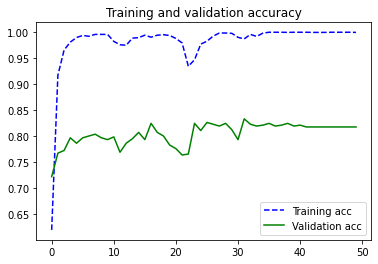

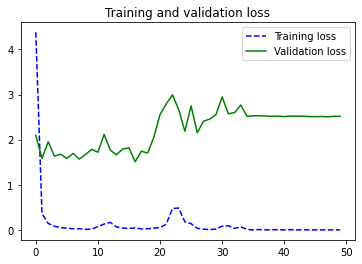

In [ ]:
plot_training_analysis(history_transfl)

Débloquage du réseau VGG:

In [ ]:
conv_base.trainable = True

model_unlocked = models.Sequential()
model_unlocked.add(conv_base) # VGG-16 layer
model_unlocked.add(layers.Flatten())
model_unlocked.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model_unlocked.add(layers.Dense(13, activation='softmax'))

model_unlocked.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_9 (Dense)              (None, 13)                3341      
Total params: 16,815,437
Trainable params: 16,815,437
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_unlocked.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

history_unlocked = model_unlocked.fit(
    train_generator_augmented,
    epochs=20,
    validation_data=(x_val, y_val))

Epoch 1/20
105/105 [==============================] - 32s 267ms/step - loss: 6.1392 - acc: 0.3207 - val_loss: 23.1933 - val_acc: 0.6261
Epoch 2/20
105/105 [==============================] - 26s 247ms/step - loss: 3.3577 - acc: 0.7028 - val_loss: 25.5904 - val_acc: 0.6800
Epoch 3/20
105/105 [==============================] - 25s 240ms/step - loss: 2.4436 - acc: 0.7688 - val_loss: 26.2512 - val_acc: 0.5878
Epoch 4/20
105/105 [==============================] - 25s 239ms/step - loss: 1.8849 - acc: 0.8388 - val_loss: 11.4865 - val_acc: 0.8087
Epoch 5/20
105/105 [==============================] - 25s 239ms/step - loss: 1.5245 - acc: 0.8729 - val_loss: 32.9980 - val_acc: 0.6870
Epoch 6/20
105/105 [==============================] - 25s 240ms/step - loss: 1.2902 - acc: 0.8879 - val_loss: 17.5700 - val_acc: 0.7965
Epoch 7/20
105/105 [==============================] - 25s 240ms/step - loss: 1.1093 - acc: 0.9067 - val_loss: 7.1176 - val_acc: 0.9009
Epoch 8/20
105/105 [=============================

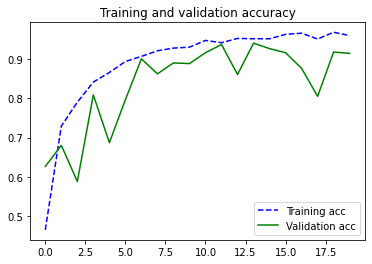

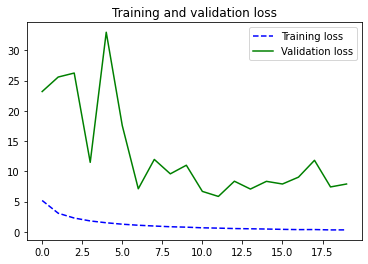

In [ ]:
plot_training_analysis(history_unlocked)

**IV- Test de Prediction des images**

In [ ]:
results = model_reg.evaluate(x_test, y_test, batch_size=32)

18/18 [==============================] - 0s 26ms/step - loss: 0.5810 - acc: 0.8995


In [ ]:
def to1D(array):
  amax = np.amax(array, axis=1)
  res = []
  for i in range(len(array)):
    m = np.where(array[i] == amax[i])[0][0]
    res.append(m)
  return res

In [ ]:
predictions = model_reg.predict(x_test)
predictions_1D = to1D(predictions)
y_test_1D = to1D(y_test)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cf = classification_report(y_test_1D, predictions_1D, target_names=labels)
print(cf)

              precision    recall  f1-score   support

          1c       0.83      1.00      0.91        15
          2c       1.00      0.33      0.50         6
          5c       0.99      0.99      0.99        84
         10c       0.83      0.96      0.89        78
         20c       0.91      0.87      0.89        71
         50c       0.90      0.84      0.87        31
          1e       1.00      0.83      0.91        59
          2e       0.79      1.00      0.88        11
          5e       0.96      0.76      0.85        34
         10e       0.84      0.84      0.84        31
         20e       0.91      0.94      0.92        52
         50e       0.94      0.90      0.92        50
        100e       0.77      0.91      0.84        45

    accuracy                           0.90       567
   macro avg       0.90      0.86      0.86       567
weighted avg       0.91      0.90      0.90       567



Normalized confusion matrix


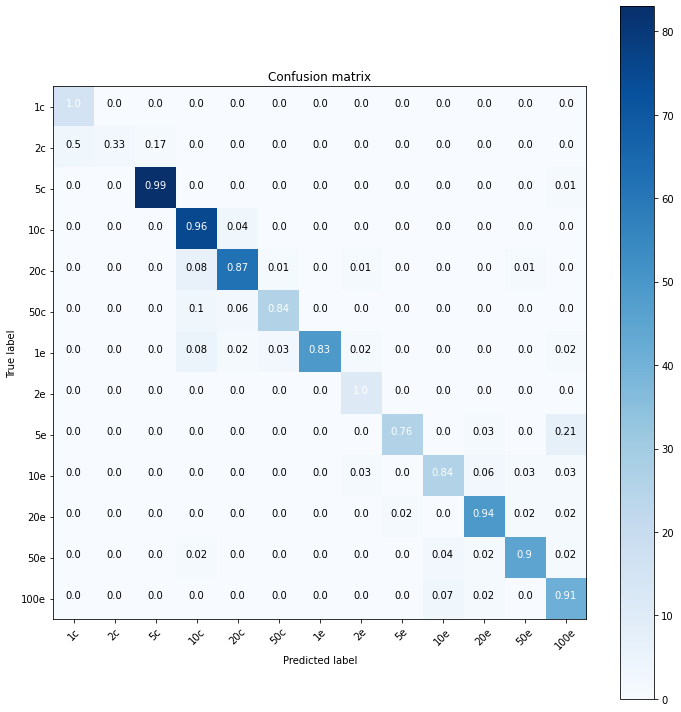

In [ ]:
confmat = confusion_matrix(y_test_1D, predictions_1D)
plot_confusion_matrix(confmat, labels)